In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, lognorm

from model import lorenz63_fdm, M63
from assimilation import EnKF, M3DVar, ExtendedKF

# L63

In [10]:
X_nature = np.load('./data/X_nature.npy')
X_ini = np.load('./data/X_ini.npy')
obs = np.load('./data/obs_normal.npy')
ts = np.load('./data/time_span.npy')
Pb = np.load('./data/Pb.npy')
R = np.load('./data/R.npy')

dt = 0.01

# generate initial ensemble
N_ens = 30
rng = np.random.RandomState(42)
X_ens_ini = rng.multivariate_normal(X_ini.ravel(), Pb, size=N_ens).T  # (3, N_ens)

def RMSE(forecast, nature):
    return np.sqrt(np.mean((forecast-nature)**2, axis=0))

### Assimilate normal distribution observation

0.8543635602186285


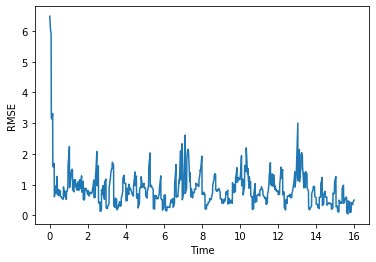

In [13]:
params = {
    'X_ens_ini': X_ens_ini, 
    'obs': obs,
    'obs_interv': 8, 
    'R': R, 
    'H_func': lambda arr: arr, 
    'alpha': 0.3,
    'inflat': 1.4
}
enkf = EnKF(lorenz63_fdm, dt)
enkf.set_params(**params)
enkf.cycle()

rmse_normal = RMSE(enkf.analysis.mean(axis=0), X_nature)
plt.plot(ts, rmse_normal)
plt.xlabel('Time')
plt.ylabel('RMSE')
print(rmse_normal.mean())

### Generate observation

In [14]:
def gen_lognorm_obs(nature, s, obs_intv):
    ndim, size = nature.shape
    
    obserr = lognorm.rvs(s=s, size=(ndim,size))
    tmean = lognorm.mean(s)
    obserr_adjust = obserr - tmean
    obs = (nature + obserr_adjust)[:,::obs_intv]
    return obs

gen_lognorm_obs(X_nature, np.sqrt(np.log(2)), 8).shape

(3, 200)

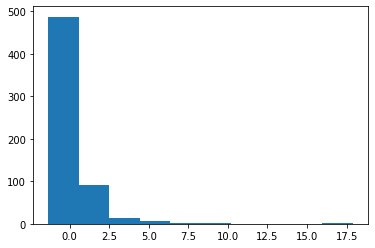

In [15]:
plt.hist((gen_lognorm_obs(X_nature, np.sqrt(np.log(2)), 8) - X_nature[:,::8]).ravel());

### assimilate full lognorm observation

In [19]:
obs = gen_lognorm_obs(X_nature, np.sqrt(np.log(2)), 8)

params = {
    'X_ens_ini': X_ens_ini, 
    'obs': obs,
    'obs_interv': 8, 
    'R': R, 
    'H_func': lambda arr: arr, 
    'alpha': 0.3,
    'inflat': 1.4
}
enkf = EnKF(lorenz63_fdm, dt)
enkf.set_params(**params)
enkf.cycle()

0.902422804905813


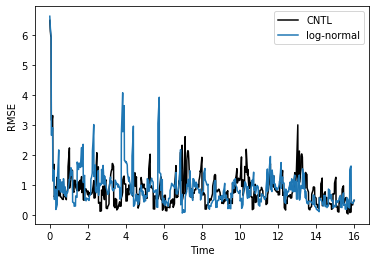

In [22]:
rmse = RMSE(enkf.analysis.mean(axis=0), X_nature)
plt.plot(ts, rmse_normal, 'k', label='CNTL')
plt.plot(ts, rmse, label='log-normal')
plt.xlabel('Time')
plt.ylabel('RMSE')
plt.legend()
print(rmse.mean())

### Repeat assimilation

In [56]:
# normal
print('normal')
rmse = []
for i in range(10):
    print(i, end=' ')

    obs = X_nature + np.random.randn(*X_nature.shape) * np.sqrt(2)
    obs = obs[:,::8]

    params = {
        'X_ens_ini': X_ens_ini, 
        'obs': obs,
        'obs_interv': 8, 
        'R': R, 
        'H_func': lambda arr: arr, 
        'alpha': 0.3,
        'inflat': 1.4
    }
    enkf = EnKF(lorenz63_fdm, dt)
    enkf.set_params(**params)
    enkf.cycle()

    rmse.append(RMSE(enkf.analysis.mean(axis=0), X_nature))

rmse1 = np.array(rmse)


# log-normal
print('\nlog-normal')
rmse = []
for i in range(10):
    print(i, end=' ')

    obs = gen_lognorm_obs(X_nature, np.sqrt(np.log(2)), 8)

    params = {
        'X_ens_ini': X_ens_ini, 
        'obs': obs,
        'obs_interv': 8, 
        'R': R, 
        'H_func': lambda arr: arr, 
        'alpha': 0.3,
        'inflat': 1.4
    }
    enkf = EnKF(lorenz63_fdm, dt)
    enkf.set_params(**params)
    enkf.cycle()

    rmse.append(RMSE(enkf.analysis.mean(axis=0), X_nature))

rmse2 = np.array(rmse)
print()

normal
0 1 2 3 4 5 6 7 8 9 
log-normal
0 1 2 3 4 5 6 7 8 9 


mean RMSE of normal:  0.8853367894260493
mean RMSE of log-normal:  0.8543598328779669


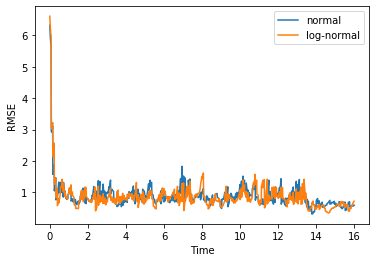

In [59]:
rmse1_mean = rmse1.mean(axis=0)
rmse2_mean = rmse2.mean(axis=0)

plt.plot(ts, rmse1_mean, label='normal')
plt.plot(ts, rmse2_mean, label='log-normal')
plt.legend()
plt.xlabel('Time')
plt.ylabel('RMSE')

print('mean RMSE of normal: ', rmse1_mean.mean())
print('mean RMSE of log-normal: ', rmse2_mean.mean())